In [2]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt

###Helpers

In [128]:
def rgb_to_hsv_standard(rgb):
    """Convert an RGB color (0-255) to standard HSV (H: 0-360, S: 0-1, V: 0-1)."""
    r, g, b = [x / 255.0 for x in rgb]  # Normalize RGB to 0-1 range
    h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert to HSV (H: 0-1, S: 0-1, V: 0-1)
    return h * 360, s, v  # Convert Hue to 0-360° range

def hsv_standard_to_rgb(hsv):
    """Convert standard HSV (H: 0-360, S: 0-1, V: 0-1) to RGB (0-255)."""
    h, s, v = hsv
    r, g, b = colorsys.hsv_to_rgb(h / 360, s, v)  # Convert HSV to RGB (0-1 range)
    return tuple(int(x * 255) for x in (r, g, b))  # Scale to 0-255 range


def display_combined_bar(input_rgb, output_rgb, black, white, pigment, red, yellow, blue):
    """Display an input color bar, a prime component bar, an output color bar, and a key below."""

    # Normalize Bk, W, P to sum to 1 for visualization
    total_base = black + white + pigment
    if total_base == 0:
        return "Invalid base ratios, sum cannot be zero."

    black /= total_base
    white /= total_base
    pigment /= total_base  # Space available for RYB

    # Normalize R, Y, B within the pigment section
    total_pigment = red + yellow + blue
    if total_pigment == 0:
        red_ratio = yellow_ratio = blue_ratio = 0
    else:
        red_ratio = (red / total_pigment) * pigment
        yellow_ratio = (yellow / total_pigment) * pigment
        blue_ratio = (blue / total_pigment) * pigment

    # Ensure values are non-negative and sum to 1
    sections = np.array([black, white, red_ratio, yellow_ratio, blue_ratio])
    sections = np.maximum(sections, 0)  # Remove negatives
    sections /= np.sum(sections)  # Normalize to sum to 1

    # Labels and colors (same order as sections)
    colors = ['black', 'white', 'red', 'yellow', 'blue']
    labels = ['Bk', 'W', 'R', 'Y', 'B']

    # --- Create Figure and Axes ---
    fig, ax = plt.subplots(figsize=(6, 5))  # Adjust figure size for better spacing

    # Bar height and spacing
    bar_height = 1
    spacing = 1.2  # Space between bars

    # --- Input Color Bar ---
    ax.barh(3 * spacing, 1.0, left=0, color=input_rgb, edgecolor='black', height=bar_height)
    ax.text(0.5, 3 * spacing, "Input Color", ha='center', va='center', fontsize=12, fontweight='bold', color='black')

    # --- Prime Color Components Bar ---
    left = 0
    for section, color in zip(sections, colors):
        if section > 0:
            ax.barh(2 * spacing, section, left=left, color=color, edgecolor='black', height=bar_height)
            left += section

    # --- Output Color Bar ---
    ax.barh(1 * spacing, 1.0, left=0, color=output_rgb, edgecolor='black', height=bar_height)
    ax.text(0.5, 1 * spacing, "Output Color", ha='center', va='center', fontsize=12, fontweight='bold', color='black')

    # --- Remove Axes for Clean Look ---
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # --- Add Key Below ---
    fig.subplots_adjust(bottom=0.3)  # Adjust spacing to fit key
    key_fig, key_ax = plt.subplots(figsize=(6, 2))

    key_ax.set_xlim(0, 1)
    key_ax.set_ylim(0, len(labels))

    for i, (label, color, value) in enumerate(zip(labels, colors, sections)):
        key_ax.add_patch(plt.Rectangle((0.1, len(labels) - i - 1), 0.1, 0.8, facecolor=color, edgecolor='black'))
        key_ax.text(0.25, len(labels) - i - 0.6, f"{label} = {value * 100:.2f}%", va='center', fontsize=12)

    key_ax.set_xticks([])
    key_ax.set_yticks([])
    key_ax.set_frame_on(False)

    plt.show()

def ryb_to_rgb(ryb, s, v):
  # gather prime rgb from ryb
  prime_red = np.array([255, 0, 0])
  prime_yellow = np.array([255, 255, 0])
  prime_blue = np.array([0, 0, 255])
  r, y, b = ryb
  prime_color = r*prime_red + y*prime_yellow + b*prime_blue

  # convert prime rgb -> prime hsv
  prime_h = rgb_to_hsv_standard(prime_color)[0]

  # convert converted hsv -> converted rgb
  return hsv_standard_to_rgb((prime_h, s, v))


###Algorithm

####Step 1: rgb -> hsv

In [108]:
def step_one(rgb):
  return rgb_to_hsv_standard(rgb)

####Step 2: extract bk, w, p ratios

In [109]:
def step_two(hsv):
  h, s, v = hsv
  bk = 1 - v
  w = (1 - s) * v
  p = 1 - (bk + w)
  return (bk, w, p)

####Step 3: extract r, y, b ratios

In [110]:
def step_three(h):
  # fetch prime rgb
  prime_r, prime_g, prime_b = hsv_standard_to_rgb((h, 1, 1))

  #solve color = x*prime_r + y*prime_y + z*prime_b for [x, y, z]
  target_color = np.array([prime_r, prime_g, prime_b])
  prime_color_matrix = np.array([[255,   0, 0],
                                 [255, 255, 0],
                                 [  0, 0, 255]]).T

  return np.round(np.linalg.solve(prime_color_matrix, target_color), 2)

####Full Function

In [121]:
def extract_color_components(rgb):
  original_hsv = step_one(original_rgb)
  bk, w, p = step_two(original_hsv)
  r, y, b = step_three(original_hsv[0])
  output_rgb = ryb_to_rgb((r, y, b), original_hsv[1], original_hsv[2])
  display_combined_bar(tuple(channel / 255.0 for channel in original_rgb),
                       tuple(channel / 255.0 for channel in output_rgb),
                       bk, w, p, r, y, b)

###Tests

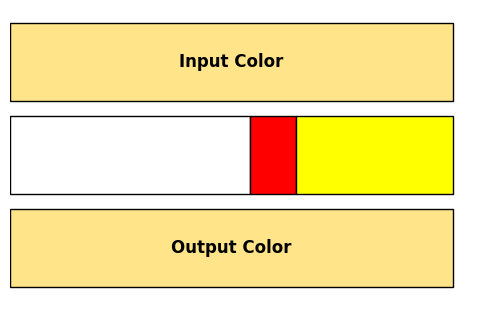

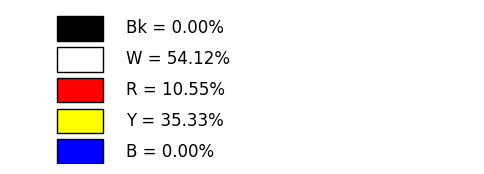

In [130]:
original_rgb = (255, 228, 138)
extract_color_components(original_rgb)